In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

from PIL import Image
import requests
from io import BytesIO

from datetime import date, time, datetime, timedelta

from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from pylab import rcParams

from scipy import stats

import warnings
import itertools
warnings.filterwarnings("ignore")

# 4 - Séries temporais

# Funções

In [231]:
def get_best_param_sarima(y, sazonalidade):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], sazonalidade) for x in list(itertools.product(p, d, q))]
    AIC = 1000000.0
    PARAM = (0,0,0)
    PARAM_S = (0, 0, 0, sazonalidade)

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}360 - AIC:{}'.format(param,param_seasonal,results.aic))
                if  results.aic < AIC:
                    AIC = results.aic
                    PARAM = param
                    PARAM_S = param_seasonal

            except: 
                continue

    print('The model with the smaller AIC:')
    print('ARIMA{}x{}12 - AIC:{}'.format(PARAM,PARAM_S,AIC))
    
    return (PARAM,PARAM_S,AIC)

In [232]:
def plot_series_sarima(y,results, title, label_y, label_results, start_date, end_date):
    '''start_date e end_date devem ser uma string no formato yyyy-mm-dd'''
    #pred = results.get_prediction(start=start_date,end = end_date, dynamic=False)
    fig, ax = plt.subplots(figsize = (15,10))
    pred = results.get_prediction(start=pd.to_datetime(start_date),end = pd.to_datetime(end_date), dynamic=False)
    pred_ci = pred.conf_int()  
    ax = y.plot(label=label_y)
    pred.predicted_mean.plot(ax=ax, label=label_results, alpha=.7, figsize=(14, 4))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('DATE')
    ax.set_ylabel('UNITS_SOLD')
    ax.set_title(title)
    plt.legend()
    plt.show()

# Carregamento dos dados

In [233]:
serie = pd.read_csv('series.csv', sep  =',')

In [234]:
serie

CATEGORY        DATE  UNITS_SOLD
0     CATEG-1  2021-08-17          59
1     CATEG-1  2020-09-19          40
2     CATEG-2  2021-10-26          23
3     CATEG-1  2021-04-27          60
4     CATEG-2  2021-05-05          61
...       ...         ...         ...
2681  CATEG-1  2021-02-18          78
2682  CATEG-2  2020-12-05           8
2683  CATEG-2  2020-02-05           3
2684  CATEG-2  2020-06-05         106
2685  CATEG-1  2021-09-03          38

[2686 rows x 3 columns]

In [235]:
serie['DATE'] = pd.to_datetime(serie['DATE'], format = '%Y-%m-%d')

In [236]:
serie['DATE'].describe()

count                    2686
unique                    921
top       2020-08-16 00:00:00
freq                        3
first     2018-09-24 00:00:00
last      2021-11-12 00:00:00
Name: DATE, dtype: object

# Separando as séries uma para cada categoria

Vamos filtrar a série para ter somente os valores referentes à categoria. Vamos transformar a data em index e ordenar pela ordem das datas. Vamos também checar se há alguma data no intervalo faltando dado. 

## Série categoria 1

In [237]:
# Filtrando apenas volores da categoria 1
serie_1 = serie[serie['CATEGORY'] == 'CATEG-1']['UNITS_SOLD']

In [238]:
# transformando as datas em índice.
serie_1.index = serie[serie['CATEGORY'] == 'CATEG-1']['DATE']
serie_1

DATE
2021-08-17    59
2020-09-19    40
2021-04-27    60
2020-03-28    26
2021-05-13    32
              ..
2019-11-01    18
2020-03-06    23
2020-11-28    96
2021-02-18    78
2021-09-03    38
Name: UNITS_SOLD, Length: 887, dtype: int64

In [239]:
# Ordenando a série pela ordem das datas
serie_1 = serie_1.sort_index()
serie_1

DATE
2018-10-16      1
2019-06-11     27
2019-06-12     26
2019-06-13     24
2019-06-14     18
             ... 
2021-11-08     63
2021-11-09     65
2021-11-10    189
2021-11-11    194
2021-11-12    146
Name: UNITS_SOLD, Length: 887, dtype: int64

In [240]:
# Importante! Excluí a primeira informação por dois motivos: primeiro, o valor muito destoante do restante; segundo, já foi possível ver que faltavam datas entre a primeira e a segunda informação.
serie_1 = serie_1.drop(index=pd.to_datetime('2018-10-16'))
serie_1.head()

DATE
2019-06-11    27
2019-06-12    26
2019-06-13    24
2019-06-14    18
2019-06-15    15
Name: UNITS_SOLD, dtype: int64

<b>Checando se há alguma data no intervalo sem informação</b> <br/>
Criei um range de todas as data que deveriam ter no intervalo, se todos os índices estiverem contidos neste range então não há nenhuma data faltando nos dados.


In [241]:
len(serie_1.index)

886

In [242]:
len(pd.date_range(start="2019-06-11",end="2021-11-12"))

886

In [243]:
(~pd.date_range(start="2019-06-11",end="2021-11-12").isin(serie_1.index)).sum()

0

## Série categoria 2

In [244]:
# Filtrando apenas volores da categoria 2
serie_2 = serie[serie['CATEGORY'] == 'CATEG-2']['UNITS_SOLD']

In [245]:
# transformando as datas em índice.
serie_2.index = serie[serie['CATEGORY'] == 'CATEG-2']['DATE']
serie_2

DATE
2021-10-26     23
2021-05-05     61
2020-08-23     28
2020-01-25      3
2019-10-14      3
             ... 
2019-11-14      3
2020-08-09     33
2020-12-05      8
2020-02-05      3
2020-06-05    106
Name: UNITS_SOLD, Length: 879, dtype: int64

In [246]:
# Ordenando a série pela ordem das datas
serie_2 = serie_2.sort_index()
serie_2

DATE
2018-10-16     1
2019-06-11    15
2019-06-12    13
2019-06-13     8
2019-06-14     9
              ..
2021-11-08    21
2021-11-09    13
2021-11-10    18
2021-11-11    20
2021-11-12    12
Name: UNITS_SOLD, Length: 879, dtype: int64

In [247]:
# Importante! Como ocorreu na série da categoria 1 ,excluí a primeira informação por dois motivos: primeiro, o valor muito destoante do restante; segundo, já foi possível ver que faltavam datas entre a primeira e a segunda informação.
serie_2 = serie_2.drop(index=pd.to_datetime('2018-10-16'))
serie_2.head()

DATE
2019-06-11    15
2019-06-12    13
2019-06-13     8
2019-06-14     9
2019-06-15     9
Name: UNITS_SOLD, dtype: int64

<b>Checando se há alguma data no intervalo sem informação</b> <br/>
Criei um range de todas as data que deveriam ter no intervalo, se todos os índices estiverem contidos neste range então não há nenhuma data faltando nos dados.


In [248]:
len(serie_2.index)

878

In [249]:
len(pd.date_range(start="2019-06-11",end="2021-11-12"))

886

Vemos que nossa série não possui observações para todas as datas no intervalo entre sua primeira data e a última. Vamos ver quais são essas datas.

In [250]:
pd.date_range(start="2019-06-11",end="2021-11-12")[~pd.date_range(start="2019-06-11",end="2021-11-12").isin(serie_2.index)]

DatetimeIndex(['2019-08-14', '2019-08-15', '2019-08-16', '2019-08-17',
               '2019-08-18', '2019-08-19', '2019-08-20', '2019-10-26'],
              dtype='datetime64[ns]', freq=None)

### Trabalhando com os dados fantantes

#### Intervalor de '2019-08-14' à '2019-08-20'

Vamos dar uma olhada nos valores vizinhos a estas datas.

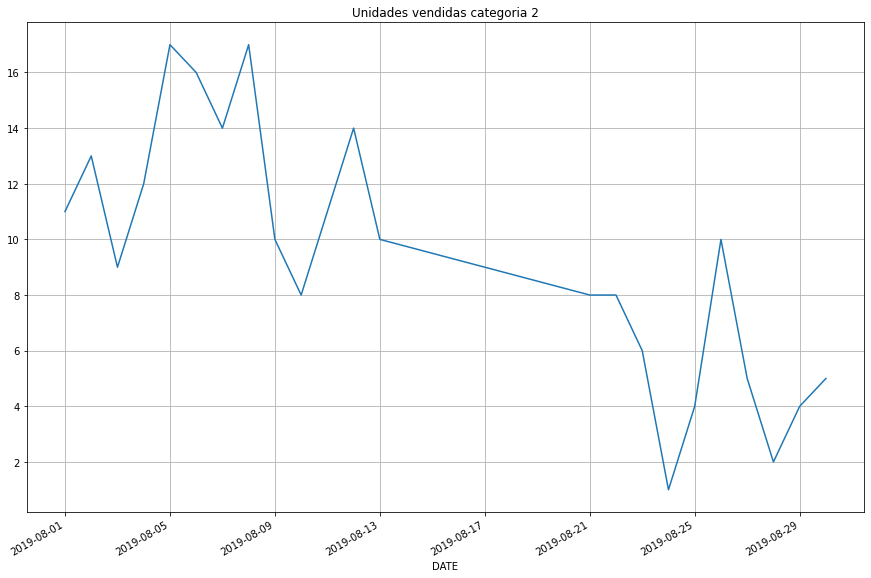

In [251]:
#'2019-08-14' e '2019-08-20'
fig, ax = plt.subplots(figsize = (15,10))
serie_2[pd.to_datetime('2019-08-01'):pd.to_datetime('2019-08-30')].plot(grid = True)
ax.set_title('Unidades vendidas categoria 2')
plt.show()

Preencher valores faltantes é sempre uma atitude delicada. Devemos entender primeiro qual o motivo destes dados estarem faltando. Neste caso, pode ser que estas datas não tiveram vendas, o que poderíamos preencher estas datas com valor zero. Mas como em toda a série não houveram dias sem vendas, acho pouco provável que este seja o motivo.


O Gráfico já liga os pontos vizinhos formando uma reta, que é uma das formas mais comuns de se preencher dados em um intervalo, e será o que vou utilizar para preencher essas datas. Quando se trata de uma série temporal, utilizar uma reta pode gerar data leakage, já que utilizaremos o valor de uma data futura para gerar a reta. Mas como este intervalo de datas ficaram na base de treino, consideramos que não se trata de datas futuras, uma vez que o treino são as datas já observadas para o modelo aprender com elas.
Para encontrar a reta vamos utilizar a equação abaixo:

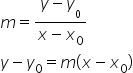

In [252]:
url = 'https://static.todamateria.com.br/upload/eq/ua/equacaodaretam.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [253]:
# Considerei os valores de x como 0 para o primeiro ponto da reta e 8 o oitavo ponto da reta
m = (serie_2[pd.to_datetime('2019-08-21')] - serie_2[pd.to_datetime('2019-08-13')])/(8-0)
m

-0.25

In [254]:
y = [0,0,0,0,0,0,0]
for i in range(0,7):
    y[i] = (m*(i-0))+serie_2[pd.to_datetime('2019-08-13')]
y

[10.0, 9.75, 9.5, 9.25, 9.0, 8.75, 8.5]

Como a quantidade de vendas só pode ser números inteiros, precisamos arredondar.

In [255]:
y = round(pd.Series(y),0)
y

0    10.0
1    10.0
2    10.0
3     9.0
4     9.0
5     9.0
6     8.0
dtype: float64

In [256]:
y.index = pd.date_range(start="2019-08-14",end="2019-08-20")

In [257]:
y

2019-08-14    10.0
2019-08-15    10.0
2019-08-16    10.0
2019-08-17     9.0
2019-08-18     9.0
2019-08-19     9.0
2019-08-20     8.0
Freq: D, dtype: float64

In [258]:
serie_2 = serie_2.append(y).sort_index()

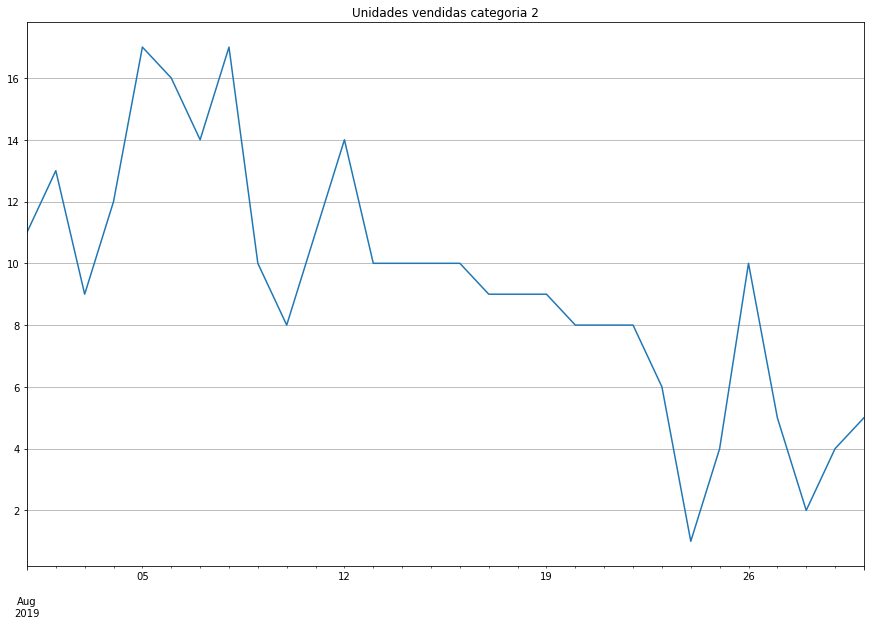

In [259]:
#'2019-08-14' e '2019-08-20'
fig, ax = plt.subplots(figsize = (15,10))
serie_2[pd.to_datetime('2019-08-01'):pd.to_datetime('2019-08-30')].plot(grid = True)
ax.set_title('Unidades vendidas categoria 2')
plt.show()

#### Data '2019-10-26'

Vamos dar uma olhada nos valores vizinhos a esta data.

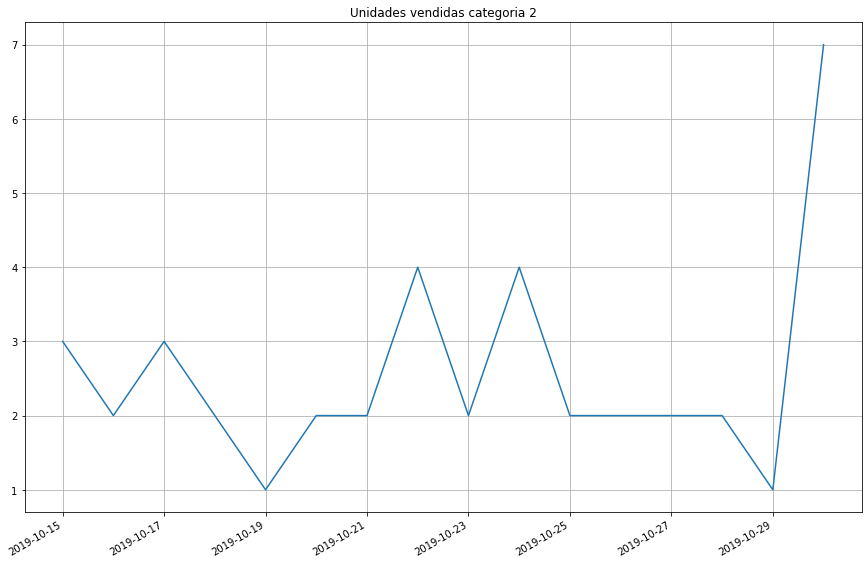

In [260]:
#'2019-10-26'
fig, ax = plt.subplots(figsize = (15,10))
serie_2[pd.to_datetime('2019-10-15'):pd.to_datetime('2019-10-30')].plot(grid = True)
ax.set_title('Unidades vendidas categoria 2')
plt.show()

In [261]:
serie_2[pd.to_datetime('2019-10-25'):pd.to_datetime('2019-10-27')]

2019-10-25    2.0
2019-10-27    2.0
dtype: float64

Neste caso vou usar a média dos valores vizinhos para preencher esta data que está faltando, ou seja, o valor 2. 

In [262]:
new_value = pd.Series(data=2, index=[pd.to_datetime('2019-10-26')])

serie_2 = serie_2.append(new_value).sort_index()

In [263]:
serie_2[pd.to_datetime('2019-10-25'):pd.to_datetime('2019-10-27')]

2019-10-25    2.0
2019-10-26    2.0
2019-10-27    2.0
dtype: float64

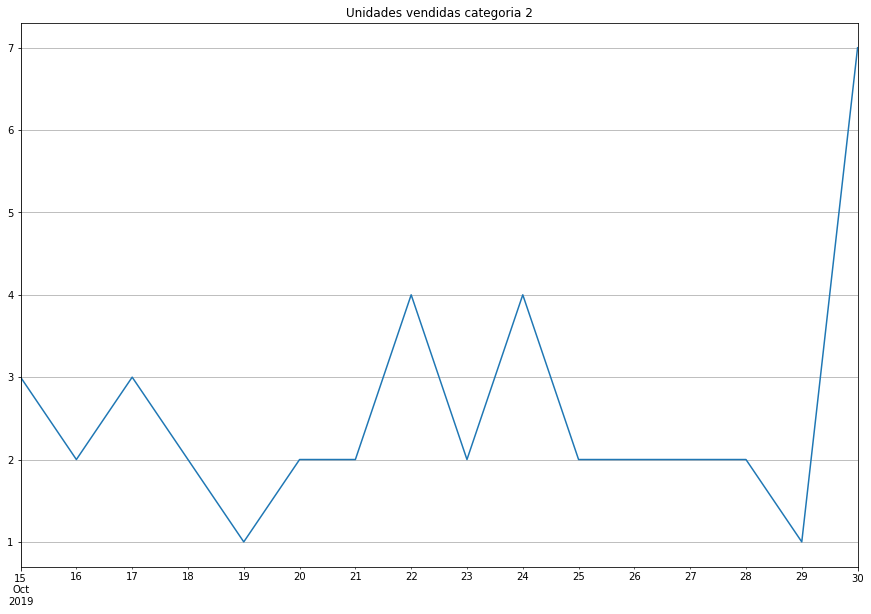

In [264]:
fig, ax = plt.subplots(figsize = (15,10))
serie_2[pd.to_datetime('2019-10-15'):pd.to_datetime('2019-10-30')].plot(grid = True)
ax.set_title('Unidades vendidas categoria 2')
plt.show()

## Série categoria 3

In [265]:
# Filtrando apenas volores da categoria 3
serie_3 = serie[serie['CATEGORY'] == 'CATEG-3']['UNITS_SOLD']

In [266]:
# transformando as datas em índice.
serie_3.index = serie[serie['CATEGORY'] == 'CATEG-3']['DATE']
serie_3

DATE
2018-10-18       1
2021-06-26    1462
2020-06-11    1373
2020-11-16    3666
2021-08-15    1929
              ... 
2019-08-28     600
2020-06-12    1534
2019-07-16     984
2021-01-21    2251
2020-08-30    1372
Name: UNITS_SOLD, Length: 920, dtype: int64

In [267]:
# Ordenando a série pela ordem das datas
serie_3 = serie_3.sort_index()
serie_3

DATE
2018-09-24       0
2018-09-25       0
2018-09-27       0
2018-09-28       2
2018-09-29       1
              ... 
2021-11-08    2812
2021-11-09    2894
2021-11-10    7551
2021-11-11    6294
2021-11-12    3829
Name: UNITS_SOLD, Length: 920, dtype: int64

In [268]:
len(serie_3.index)

920

In [269]:
len(pd.date_range(start="2018-09-24",end="2021-11-12"))

1146

In [270]:
datas_faltando_serie3 = pd.date_range(start="2018-09-24",end="2021-11-12")[~pd.date_range(start="2018-09-24",end="2021-11-12").isin(serie_3.index)]
datas_faltando_serie3

DatetimeIndex(['2018-09-26', '2018-10-16', '2018-10-17', '2018-10-26',
               '2018-10-27', '2018-10-28', '2018-10-30', '2018-10-31',
               '2018-11-01', '2018-11-02',
               ...
               '2019-06-01', '2019-06-02', '2019-06-03', '2019-06-04',
               '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10'],
              dtype='datetime64[ns]', length=226, freq=None)

### Trabalhando com os dados faltantes

In [271]:
serie_3.index

DatetimeIndex(['2018-09-24', '2018-09-25', '2018-09-27', '2018-09-28',
               '2018-09-29', '2018-09-30', '2018-10-01', '2018-10-02',
               '2018-10-03', '2018-10-04',
               ...
               '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06',
               '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12'],
              dtype='datetime64[ns]', name='DATE', length=920, freq=None)

In [272]:
list(datas_faltando_serie3.unique())

[Timestamp('2018-09-26 00:00:00'),
 Timestamp('2018-10-16 00:00:00'),
 Timestamp('2018-10-17 00:00:00'),
 Timestamp('2018-10-26 00:00:00'),
 Timestamp('2018-10-27 00:00:00'),
 Timestamp('2018-10-28 00:00:00'),
 Timestamp('2018-10-30 00:00:00'),
 Timestamp('2018-10-31 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-11-02 00:00:00'),
 Timestamp('2018-11-04 00:00:00'),
 Timestamp('2018-11-06 00:00:00'),
 Timestamp('2018-11-07 00:00:00'),
 Timestamp('2018-11-09 00:00:00'),
 Timestamp('2018-11-10 00:00:00'),
 Timestamp('2018-11-12 00:00:00'),
 Timestamp('2018-11-13 00:00:00'),
 Timestamp('2018-11-14 00:00:00'),
 Timestamp('2018-11-15 00:00:00'),
 Timestamp('2018-11-16 00:00:00'),
 Timestamp('2018-11-17 00:00:00'),
 Timestamp('2018-11-18 00:00:00'),
 Timestamp('2018-11-19 00:00:00'),
 Timestamp('2018-11-20 00:00:00'),
 Timestamp('2018-11-21 00:00:00'),
 Timestamp('2018-11-22 00:00:00'),
 Timestamp('2018-11-23 00:00:00'),
 Timestamp('2018-11-24 00:00:00'),
 Timestamp('2018-11-

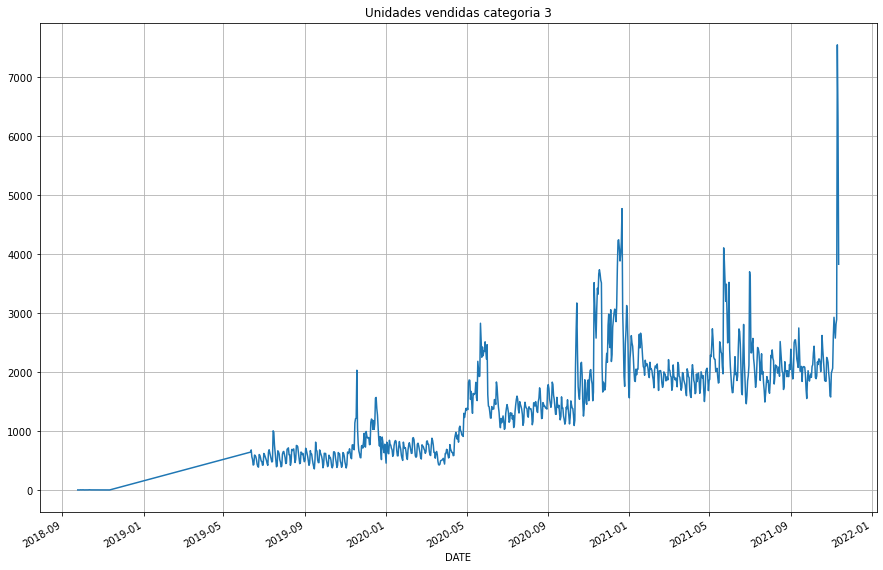

In [273]:
fig, ax = plt.subplots(figsize = (15,10))
serie_3.plot(grid = True)
ax.set_title('Unidades vendidas categoria 3')
plt.show()

Como se trata de uma série diária, onde temos vários anos de dados e estas datas que estão faltando estão no início, optei por excluir os dados até a última data que falta 2019-06-10.

In [274]:
serie_3 = serie_3[pd.date_range(start="2019-06-11",end="2021-11-12")]

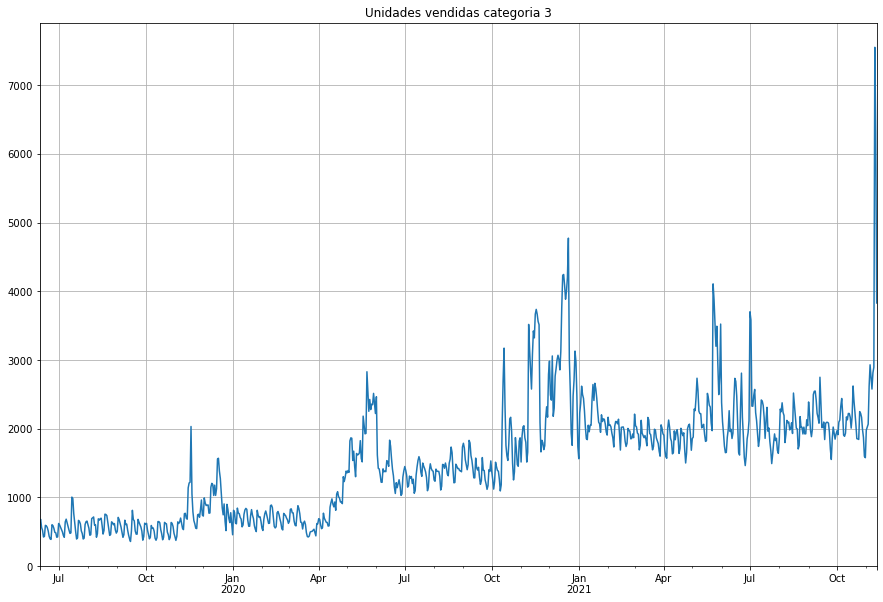

In [275]:
fig, ax = plt.subplots(figsize = (15,10))
serie_3.plot(grid = True)
ax.set_title('Unidades vendidas categoria 3')
plt.show()

In [276]:
serie_3

2019-06-11     642
2019-06-12     679
2019-06-13     561
2019-06-14     520
2019-06-15     422
              ... 
2021-11-08    2812
2021-11-09    2894
2021-11-10    7551
2021-11-11    6294
2021-11-12    3829
Freq: D, Name: UNITS_SOLD, Length: 886, dtype: int64

# Modelagem série categoria 1

## Espiada na série_1

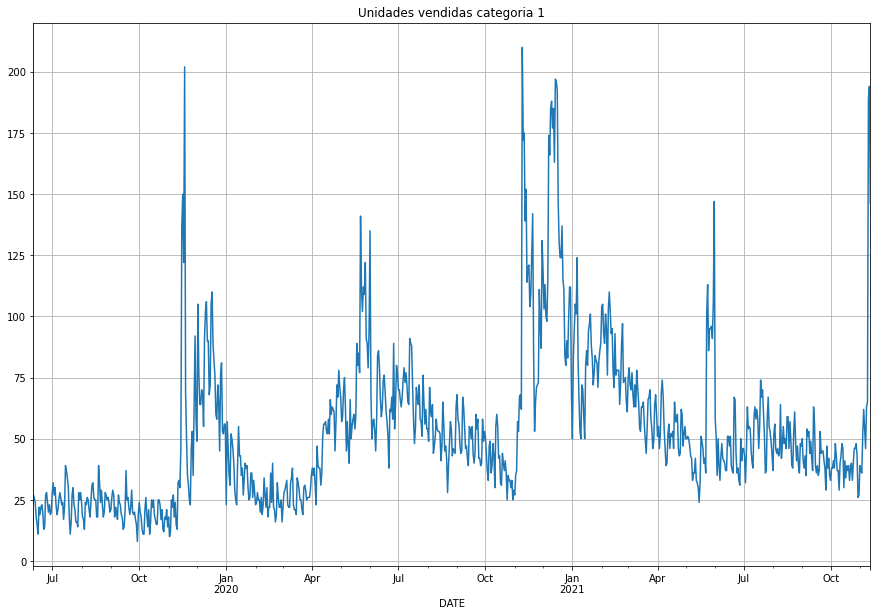

In [277]:
fig, ax = plt.subplots(figsize = (15,10))
serie_1.plot(grid = True)
ax.set_title('Unidades vendidas categoria 1')
plt.show()

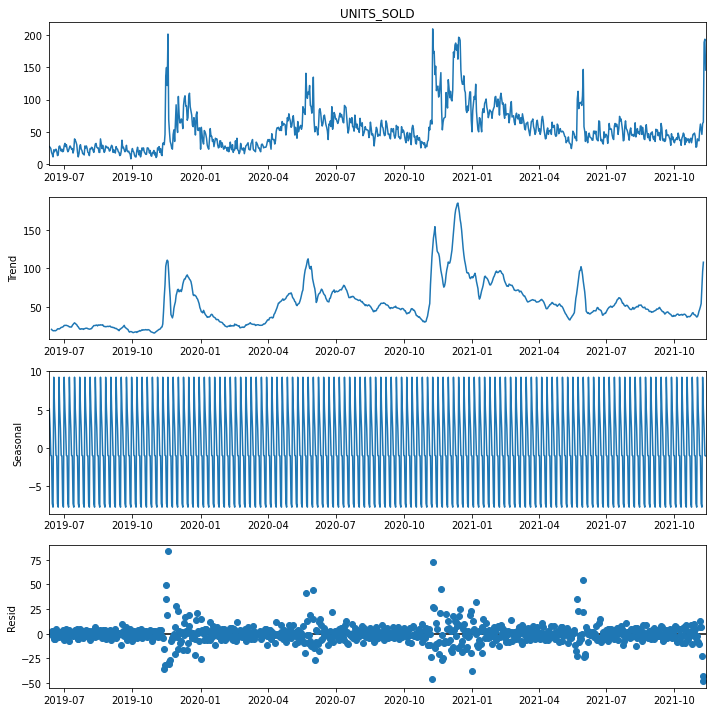

In [278]:
decomposition = sm.tsa.seasonal_decompose(serie_1, model='additive')

rcParams['figure.figsize'] = 10, 10
fig = decomposition.plot()
plt.show()

In [279]:
serie_1.index

DatetimeIndex(['2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-15', '2019-06-16', '2019-06-17', '2019-06-18',
               '2019-06-19', '2019-06-20',
               ...
               '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06',
               '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12'],
              dtype='datetime64[ns]', name='DATE', length=886, freq=None)

## FAC e FACP

Os gráficos a seguir mostram os valores de autocorrelação da série (FAC) e autocorrelação parcial (FACP).

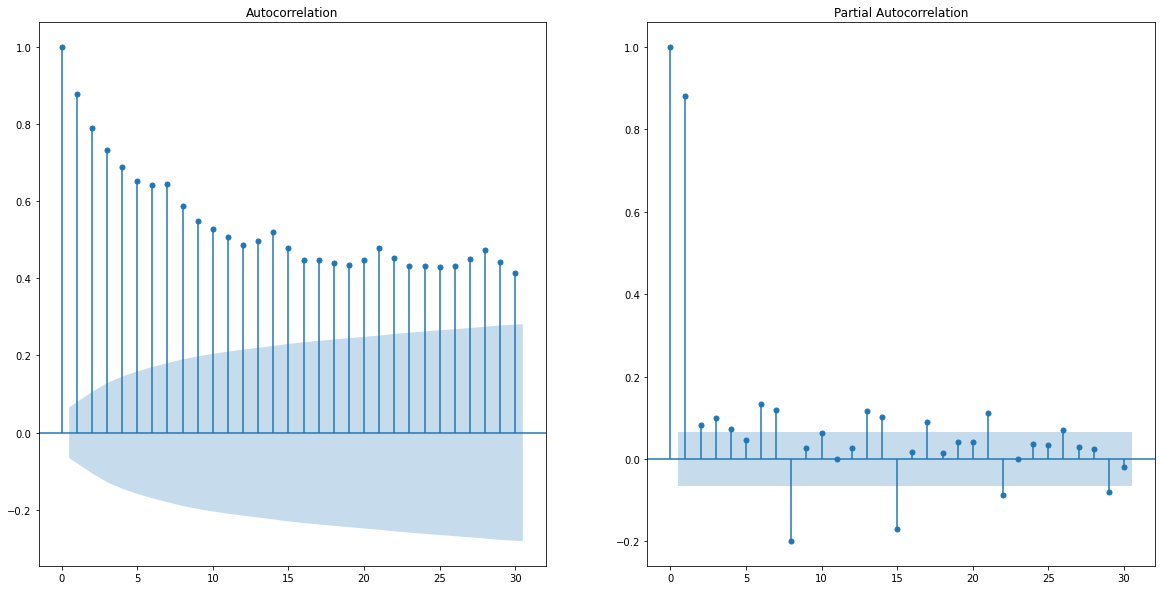

In [280]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(serie_1, ax = ax1)
plot_pacf(serie_1, ax = ax2)
plt.show()

## Serie-1 diferenciada

In [281]:
serie_1

DATE
2019-06-11     27
2019-06-12     26
2019-06-13     24
2019-06-14     18
2019-06-15     15
             ... 
2021-11-08     63
2021-11-09     65
2021-11-10    189
2021-11-11    194
2021-11-12    146
Name: UNITS_SOLD, Length: 886, dtype: int64

In [282]:
serie_1_diff = serie_1[pd.date_range(start="2019-06-11",end="2021-11-11")].reset_index(drop=True)-serie_1[pd.date_range(start="2019-06-12",end="2021-11-12")].reset_index(drop=True)

In [283]:
serie_1_diff

0        1
1        2
2        6
3        3
4        4
      ... 
880    -17
881     -2
882   -124
883     -5
884     48
Name: UNITS_SOLD, Length: 885, dtype: int64

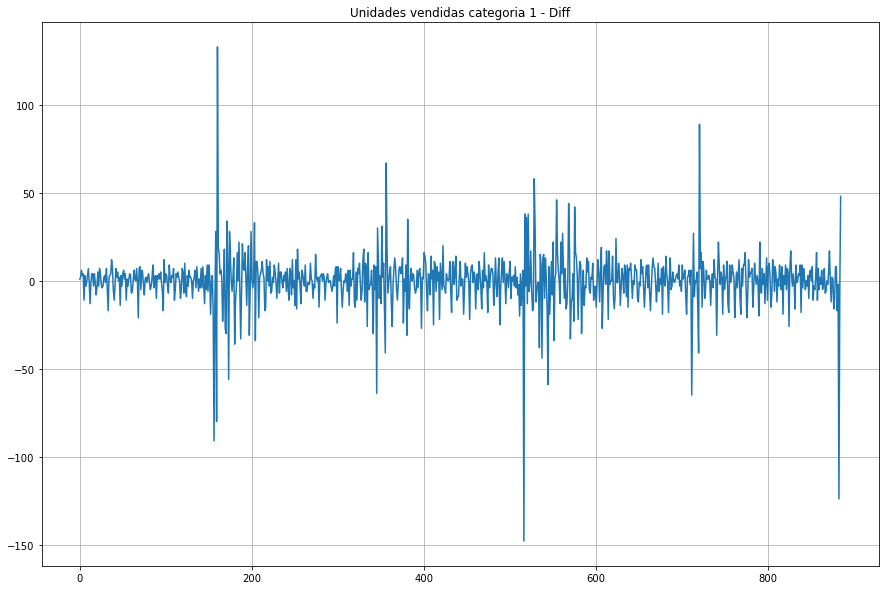

In [284]:
fig, ax = plt.subplots(figsize = (15,10))
serie_1_diff.plot(grid = True)
ax.set_title('Unidades vendidas categoria 1 - Diff')
plt.show()

Podemos ver que com a diferenciação a série se torna estacionária.

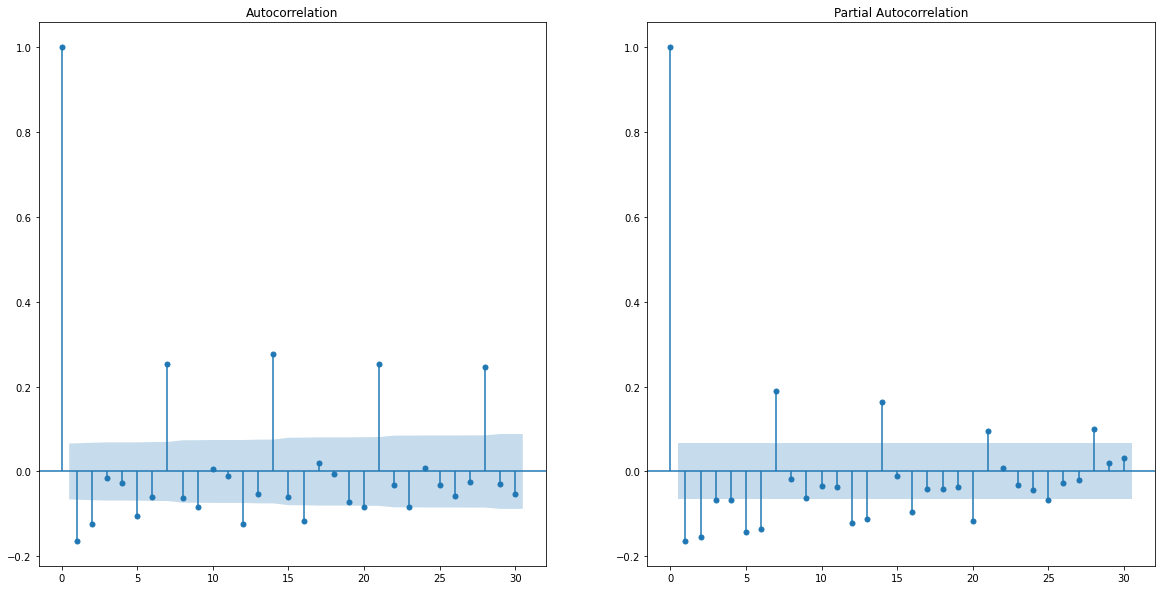

In [285]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(serie_1_diff, ax = ax1)
plot_pacf(serie_1_diff, ax = ax2)
plt.show()

Através da FAC e FACP da série diferenciada pude ver a sazonalidade de 7 dias que não era muito clara de se ver na série.

## Ajuste da série

Removi os últimos 21 dias da série para validação.

In [286]:
pd.to_datetime('2021-11-12') - timedelta(days=21)

Timestamp('2021-10-22 00:00:00')

In [287]:
serie_1_treino = serie_1[pd.date_range(start="2019-06-11",end="2021-10-22")]
serie_1_validação = serie_1[pd.date_range(start="2021-10-23",end="2021-11-12")]

In [288]:
get_best_param_sarima(y = serie_1_treino, sazonalidade = 7)

The model with the smaller AIC:
ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:6735.494882499188


((1, 0, 1), (0, 1, 1, 7), 6735.494882499188)

Treinando modelos Sarima com sazonalidade de 7 dias e um range de parâmetros de 0 a 2, pudemos ver que a combinação de parâmetros que gerou menor AIC foi (1, 0, 1)(0, 1, 1, 7).

In [289]:
mod = sm.tsa.statespace.SARIMAX(serie_1_treino,
                                order=(1, 0, 1), 
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [290]:
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        UNITS_SOLD   No. Observations:                  865
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3363.747
Date:                           Wed, 02 Mar 2022   AIC                           6735.495
Time:                                   09:05:21   BIC                           6754.471
Sample:                               06-11-2019   HQIC                          6742.764
                                    - 10-22-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9405      0.008    125.145      0.000       0.926       0.955
ma.L1         -0.1954      0.020     -9.678

In [291]:
pd.to_datetime('2021-11-12') + timedelta(days=21)

Timestamp('2021-12-03 00:00:00')

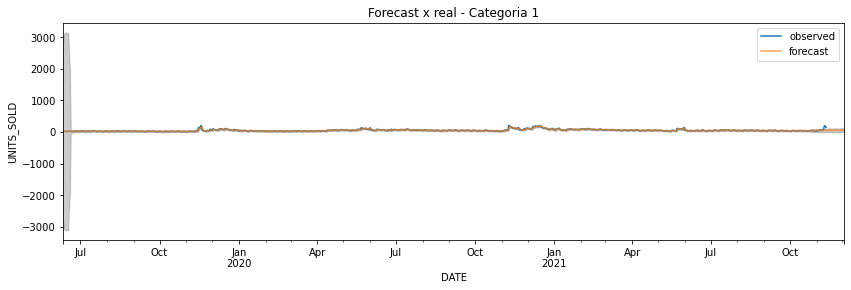

In [292]:
plot_series_sarima(serie_1[pd.date_range(start="2019-06-11",end="2021-11-12")], results, "Forecast x real - Categoria 1", 'observed','forecast', start_date = '2019-06-11',end_date='2021-12-03')

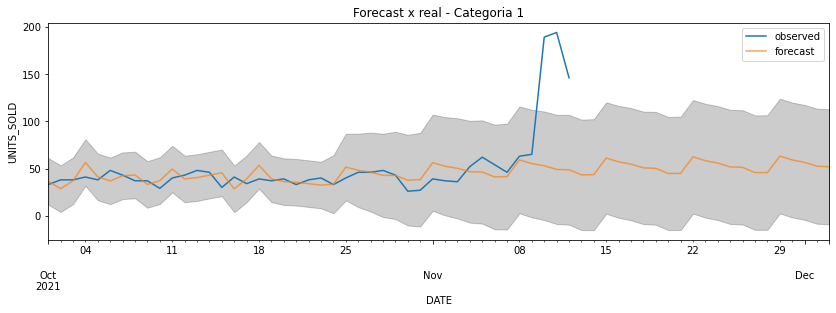

In [293]:
plot_series_sarima(serie_1[pd.date_range(start="2021-10-01",end="2021-11-12")], results, "Forecast x real - Categoria 1", 'observed','forecast', start_date = '2021-10-01',end_date='2021-12-03')

In [294]:
forecast = results.get_prediction(start='2019-06-11',end = '2021-12-03', dynamic=False).predicted_mean
pd.DataFrame({'real':serie_1,'forecast':forecast, 'difference':forecast - serie_1 }).tail(50)

real   forecast  difference
2021-10-15   30.0  45.432597   15.432597
2021-10-16   41.0  28.462173  -12.537827
2021-10-17   34.0  39.068914    5.068914
2021-10-18   39.0  53.371604   14.371604
2021-10-19   37.0  39.076656    2.076656
2021-10-20   39.0  36.091394   -2.908606
2021-10-21   33.0  35.469022    2.469022
2021-10-22   38.0  33.992294   -4.007706
2021-10-23   40.0  32.463534   -7.536466
2021-10-24   33.0  33.357027    0.357027
2021-10-25   40.0  51.538853   11.538853
2021-10-26   46.0  48.073763    2.073763
2021-10-27   46.0  46.158852    0.158852
2021-10-28   48.0  42.716015   -5.283985
2021-10-29   43.0  42.727000   -0.273000
2021-10-30   26.0  37.678242   11.678242
2021-10-31   27.0  38.261221   11.261221
2021-11-01   39.0  56.151023   17.151023
2021-11-02   37.0  52.411298   15.411298
2021-11-03   36.0  50.238105   14.238105
2021-11-04   52.0  46.552367   -5.447633
2021-11-05   62.0  46.334913  -15.665087
2021-11-06   54.0  41.071319  -12.928681
2021-11-07   46.0  41.452255   -4.547745
2021-11-08   63.0  59.152044   -3.847956
2021-11-09   65.0  55.233621   -9.766379
2021-11-10  189.0  52.892371 -136.107629
2021-11-11  194.0  49.048582 -144.951418
2021-11-12  146.0  48.682489  -97.317511
2021-11-13    NaN  43.279107         NaN
2021-11-14    NaN  43.528578         NaN
2021-11-15    NaN  61.104732         NaN
2021-11-16    NaN  57.070034         NaN
2021-11-17    NaN  54.619433         NaN
2021-11-18    NaN  50.672805         NaN
2021-11-19    NaN  50.209997         NaN
2021-11-20    NaN  44.715658         NaN
2021-11-21    NaN  44.879589         NaN
2021-11-22    NaN  62.375295         NaN
2021-11-23    NaN  58.264941         NaN
2021-11-24    NaN  55.743189         NaN
2021-11-25    NaN  51.729646         NaN
2021-11-26    NaN  51.203907         NaN
2021-11-27    NaN  45.650385         NaN
2021-11-28    NaN  45.758657         NaN
2021-11-29    NaN  63.202018         NaN
2021-11-30    NaN  59.042437         NaN
2021-12-01    NaN  56.474387         NaN
2021-12-02    NaN  52.417305         NaN
2021-12-03    NaN  51.850618         NaN

In [295]:
erro = forecast[pd.date_range(start="2019-06-11",end="2021-11-12")] - serie_1

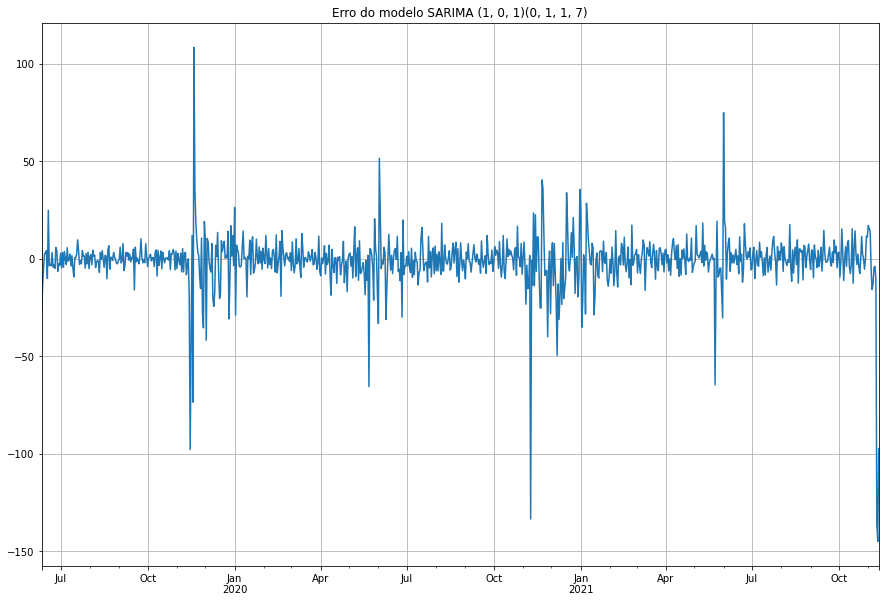

In [296]:
fig, ax = plt.subplots(figsize = (15,10))
erro.plot(grid = True)
ax.set_title('Erro do modelo SARIMA (1, 0, 1)(0, 1, 1, 7)')
plt.show()

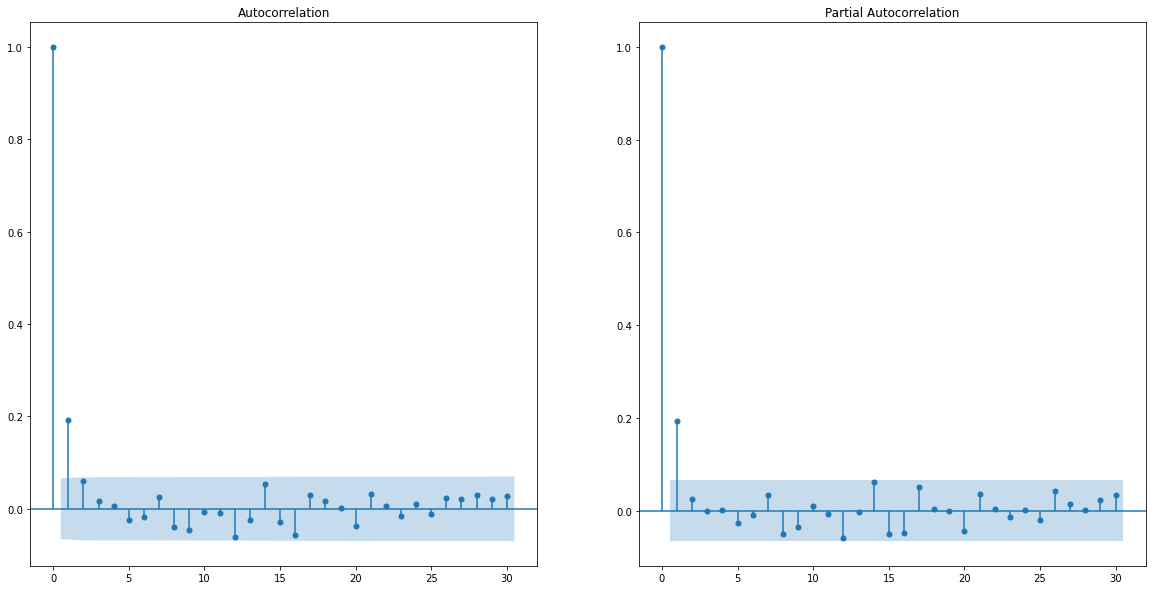

In [297]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(erro, ax = ax1)
plot_pacf(erro, ax = ax2)
plt.show()

Queremos testar se o erro gerado é aleatório com distribuição normal. Vamos utilizar para isto, o teste de Shapiro-Wilk.

In [227]:
shapiro_test = stats.shapiro(erro)
shapiro_test

ShapiroResult(statistic=0.6491998434066772, pvalue=3.978025698703791e-39)

Como o p-valor é menor que 0,05, ou seja, a probabilidade da estatística do teste ser maior que o valor observado é muito pequena, não rejeitamos a hipótese nula de que o erro é normalmente distribuído.

# Modelagem série categoria 2

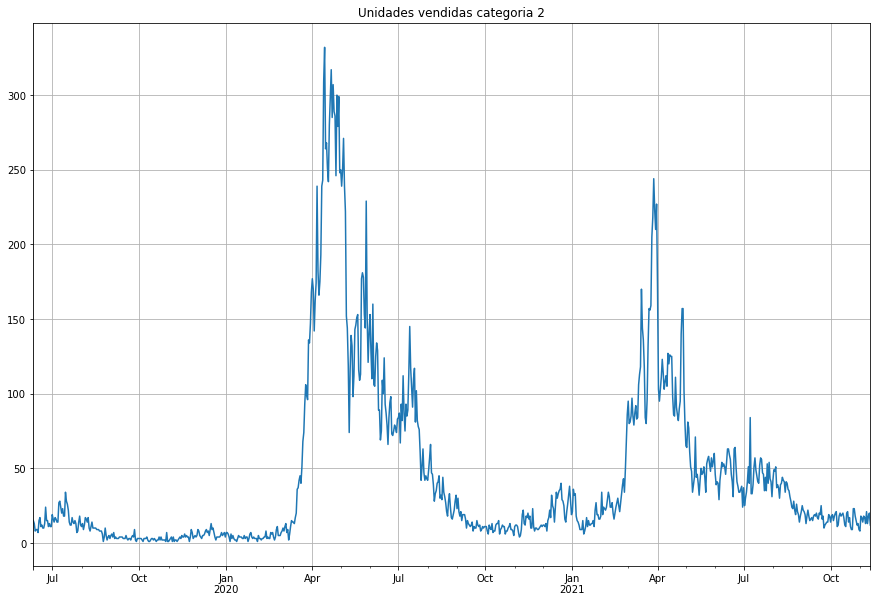

In [300]:
fig, ax = plt.subplots(figsize = (15,10))
serie_2.plot(grid = True)
ax.set_title('Unidades vendidas categoria 2')
plt.show()

## Serie_2 diferenciada

In [301]:
serie_2

2019-06-11    15.0
2019-06-12    13.0
2019-06-13     8.0
2019-06-14     9.0
2019-06-15     9.0
              ... 
2021-11-08    21.0
2021-11-09    13.0
2021-11-10    18.0
2021-11-11    20.0
2021-11-12    12.0
Length: 886, dtype: float64

In [302]:
serie_2_diff = serie_2[pd.date_range(start="2019-06-11",end="2021-11-11")].reset_index(drop=True)-serie_2[pd.date_range(start="2019-06-12",end="2021-11-12")].reset_index(drop=True)

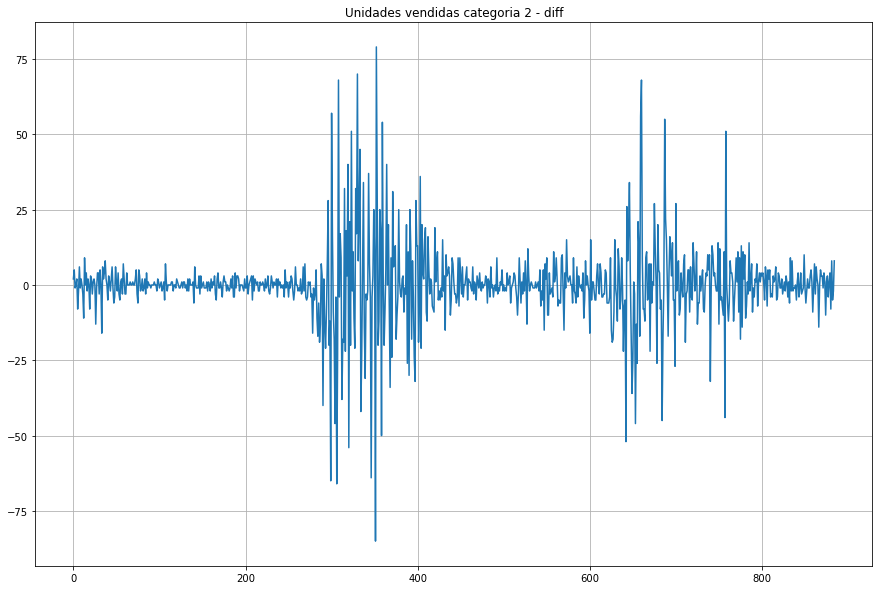

In [303]:
fig, ax = plt.subplots(figsize = (15,10))
serie_2_diff.plot(grid = True)
ax.set_title('Unidades vendidas categoria 2 - diff')
plt.show()

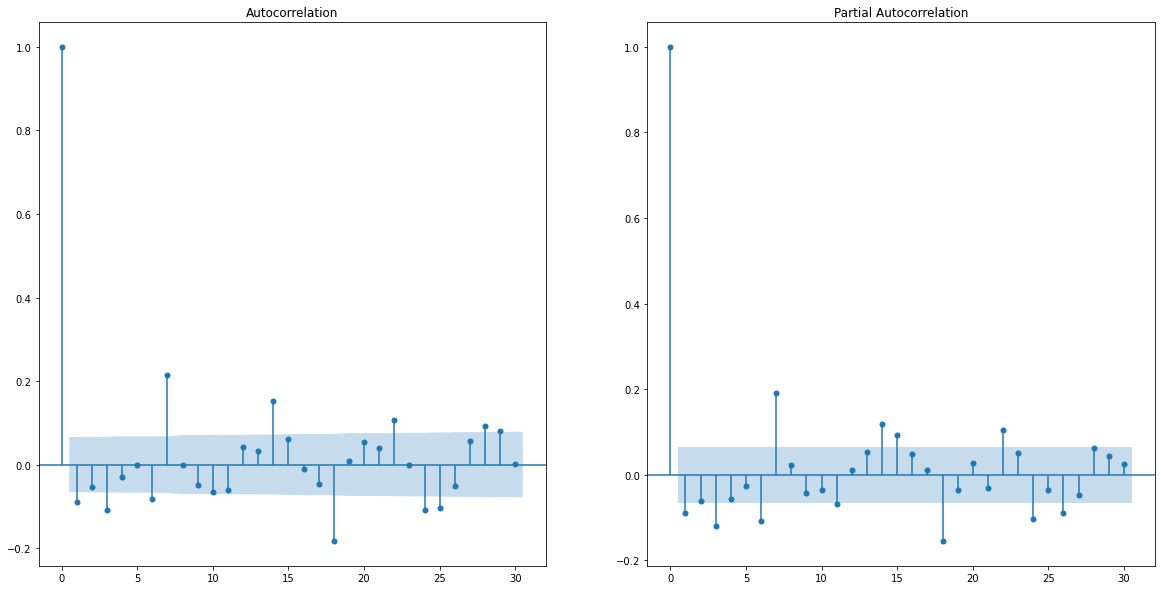

In [304]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(serie_2_diff, ax = ax1)
plot_pacf(serie_2_diff, ax = ax2)
plt.show()

## Ajuste da serie_2

In [305]:
serie_2_treino = serie_2[pd.date_range(start="2019-06-11",end="2021-10-22")]
serie_2_validação = serie_2[pd.date_range(start="2021-10-23",end="2021-11-12")]

In [306]:
get_best_param_sarima(y = serie_2_treino, sazonalidade = 7)

The model with the smaller AIC:
ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:6723.747845852718


((1, 1, 1), (1, 1, 1, 7), 6723.747845852718)

In [307]:
mod = sm.tsa.statespace.SARIMAX(serie_2_treino,
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [308]:
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  865
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3356.874
Date:                           Wed, 02 Mar 2022   AIC                           6723.748
Time:                                   09:07:27   BIC                           6747.462
Sample:                               06-11-2019   HQIC                          6732.833
                                    - 10-22-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6183      0.077      8.024      0.000       0.467       0.769
ma.L1         -0.7306      0.068    -10.727

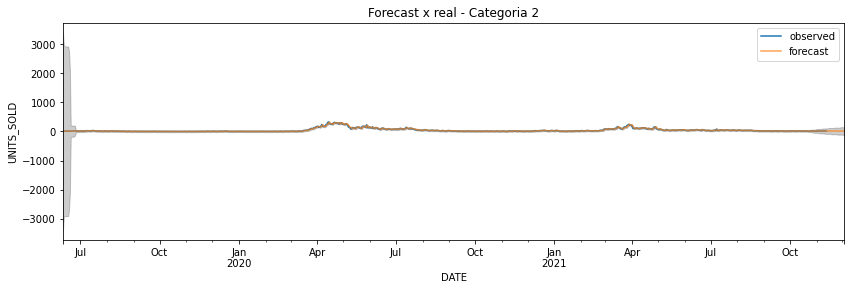

In [309]:
plot_series_sarima(serie_2[pd.date_range(start="2019-06-11",end="2021-11-12")], results, "Forecast x real - Categoria 2", 'observed','forecast', start_date = '2019-06-11',end_date='2021-12-03')

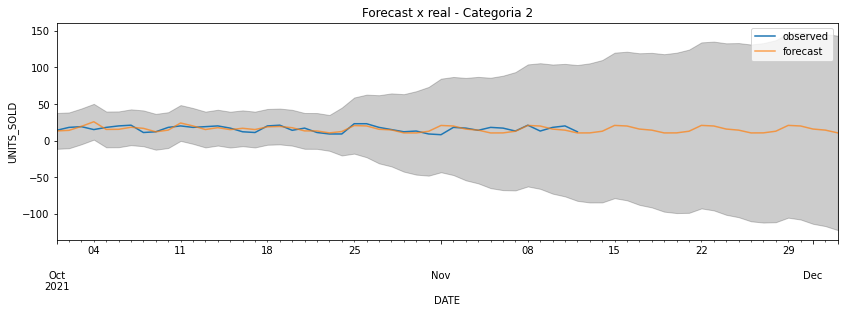

In [310]:
plot_series_sarima(serie_2[pd.date_range(start="2021-10-01",end="2021-11-12")], results, "Forecast x real - Categoria 2", 'observed','forecast', start_date = '2021-10-01',end_date='2021-12-03')

In [311]:
forecast = results.get_prediction(start='2019-06-11',end = '2021-12-03', dynamic=False).predicted_mean
pd.DataFrame({'real':serie_2,'forecast':forecast, 'difference':forecast - serie_2 }).tail(50)

real   forecast  difference
2021-10-15  17.0  14.936258   -2.063742
2021-10-16  12.0  16.765806    4.765806
2021-10-17  11.0  15.053224    4.053224
2021-10-18  20.0  18.711771   -1.288229
2021-10-19  21.0  19.232893   -1.767107
2021-10-20  14.0  17.521599    3.521599
2021-10-21  17.0  13.202905   -3.797095
2021-10-22  11.0  13.122939    2.122939
2021-10-23   9.0  10.467454    1.467454
2021-10-24   9.0  12.334193    3.334193
2021-10-25  23.0  20.483292   -2.516708
2021-10-26  23.0  19.951447   -3.048553
2021-10-27  18.0  15.393418   -2.606582
2021-10-28  15.0  14.560898   -0.439102
2021-10-29  12.0  10.453388   -1.546612
2021-10-30  13.0  10.440673   -2.559327
2021-10-31   9.0  12.643505    3.643505
2021-11-01   8.0  20.631902   12.631902
2021-11-02  18.0  19.859422    1.859422
2021-11-03  17.0  15.628672   -1.371328
2021-11-04  14.0  14.248069    0.248069
2021-11-05  18.0  10.400379   -7.599621
2021-11-06  17.0  10.456963   -6.543037
2021-11-07  13.0  12.704705   -0.295295
2021-11-08  21.0  20.669106   -0.330894
2021-11-09  13.0  19.861945    6.861945
2021-11-10  18.0  15.676624   -2.323376
2021-11-11  20.0  14.218696   -5.781304
2021-11-12  12.0  10.407294   -1.592706
2021-11-13   NaN  10.473484         NaN
2021-11-14   NaN  12.727455         NaN
2021-11-15   NaN  20.688436         NaN
2021-11-16   NaN  19.876373         NaN
2021-11-17   NaN  15.697416         NaN
2021-11-18   NaN  14.228614         NaN
2021-11-19   NaN  10.422303         NaN
2021-11-20   NaN  10.489837         NaN
2021-11-21   NaN  12.744680         NaN
2021-11-22   NaN  20.705179         NaN
2021-11-23   NaN  19.892427         NaN
2021-11-24   NaN  15.714362         NaN
2021-11-25   NaN  14.244033         NaN
2021-11-26   NaN  10.438436         NaN
2021-11-27   NaN  10.506159         NaN
2021-11-28   NaN  12.761125         NaN
2021-11-29   NaN  20.721557         NaN
2021-11-30   NaN  19.908707         NaN
2021-12-01   NaN  15.730768         NaN
2021-12-02   NaN  14.260224         NaN
2021-12-03   NaN  10.454727         NaN

In [312]:
erro = forecast[pd.date_range(start="2019-06-11",end="2021-11-12")] - serie_2

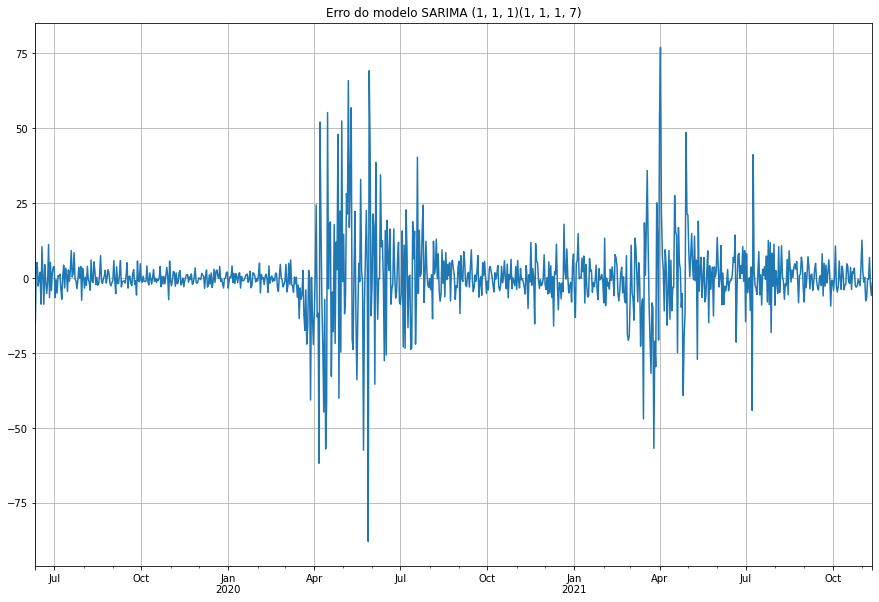

In [313]:
fig, ax = plt.subplots(figsize = (15,10))
erro.plot(grid = True)
ax.set_title('Erro do modelo SARIMA (1, 1, 1)(1, 1, 1, 7)')
plt.show()

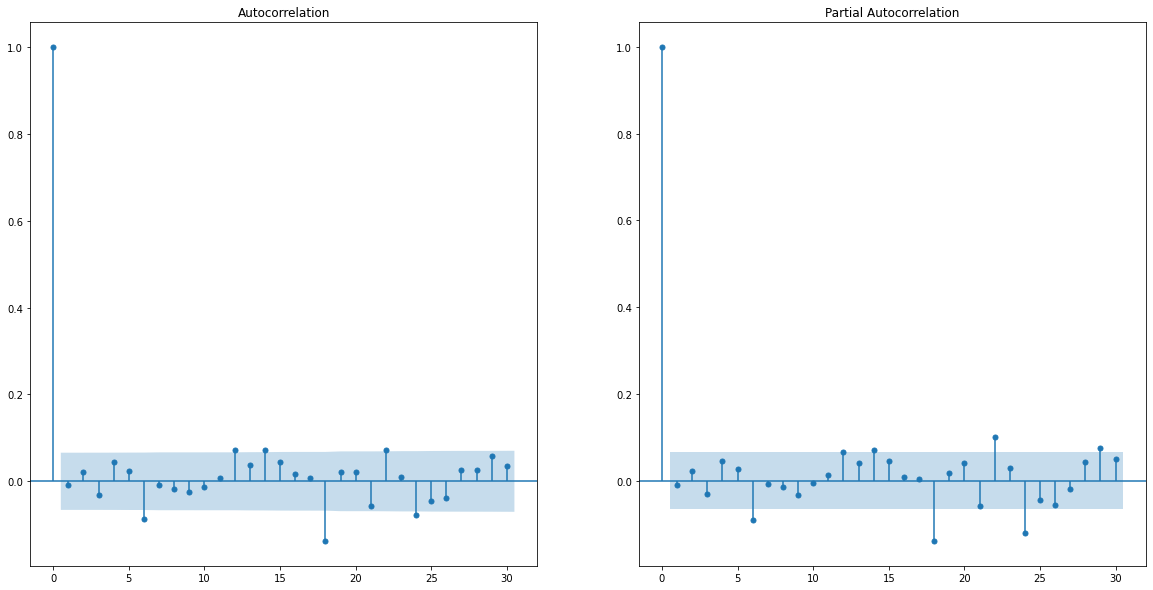

In [314]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(erro, ax = ax1)
plot_pacf(erro, ax = ax2)
plt.show()

Queremos testar se o erro gerado é aleatório com distribuição normal. Vamos utilizar para isto, o teste de Shapiro-Wilk.

In [316]:
erro.mean()

0.0676654039647069

In [317]:
erro.var()

152.35546126494415

In [318]:
shapiro_test = stats.shapiro(erro)
shapiro_test

ShapiroResult(statistic=0.7870725393295288, pvalue=1.8916410680473374e-32)

Como o p-valor é menor que 0,05, ou seja, a probabilidade da estatística do teste ser maior que o valor observado é muito pequena, não rejeitamos a hipótese nula de que o erro é normalmente distribuído.

# Modelagem série categoria 3

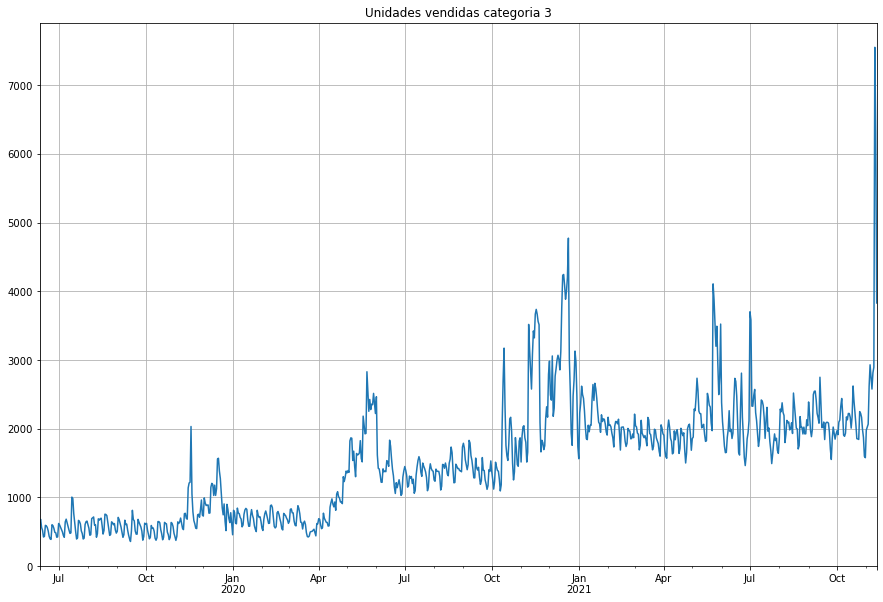

In [319]:
fig, ax = plt.subplots(figsize = (15,10))
serie_3.plot(grid = True)
ax.set_title('Unidades vendidas categoria 3')
plt.show()

## Série diferenciada

In [320]:
serie_3

2019-06-11     642
2019-06-12     679
2019-06-13     561
2019-06-14     520
2019-06-15     422
              ... 
2021-11-08    2812
2021-11-09    2894
2021-11-10    7551
2021-11-11    6294
2021-11-12    3829
Freq: D, Name: UNITS_SOLD, Length: 886, dtype: int64

In [321]:
serie_3_diff = serie_3[pd.date_range(start="2019-06-11",end="2021-11-11")].reset_index(drop=True)-serie_3[pd.date_range(start="2019-06-12",end="2021-11-12")].reset_index(drop=True)

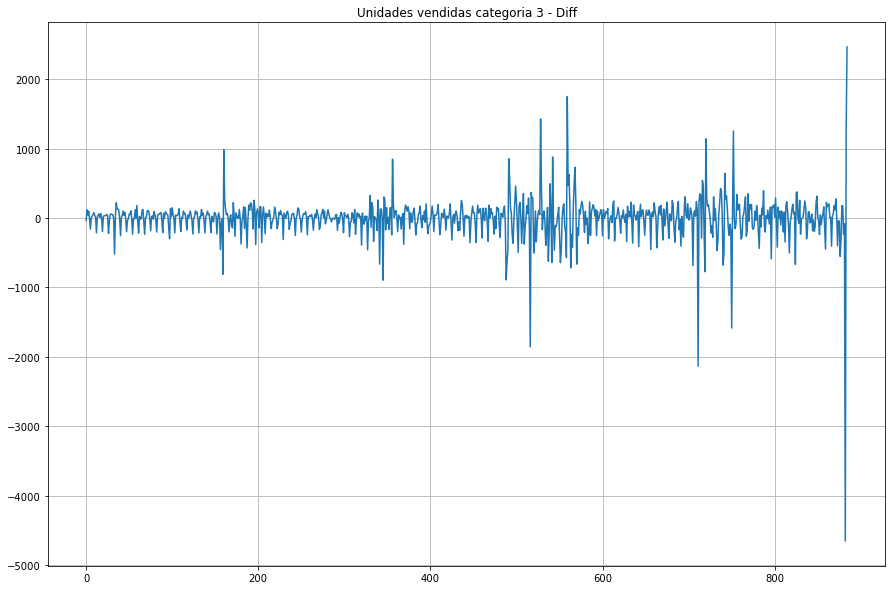

In [322]:
fig, ax = plt.subplots(figsize = (15,10))
serie_3_diff.plot(grid = True)
ax.set_title('Unidades vendidas categoria 3 - Diff')
plt.show()

Após a diferenciação a série se tornou estacionária.

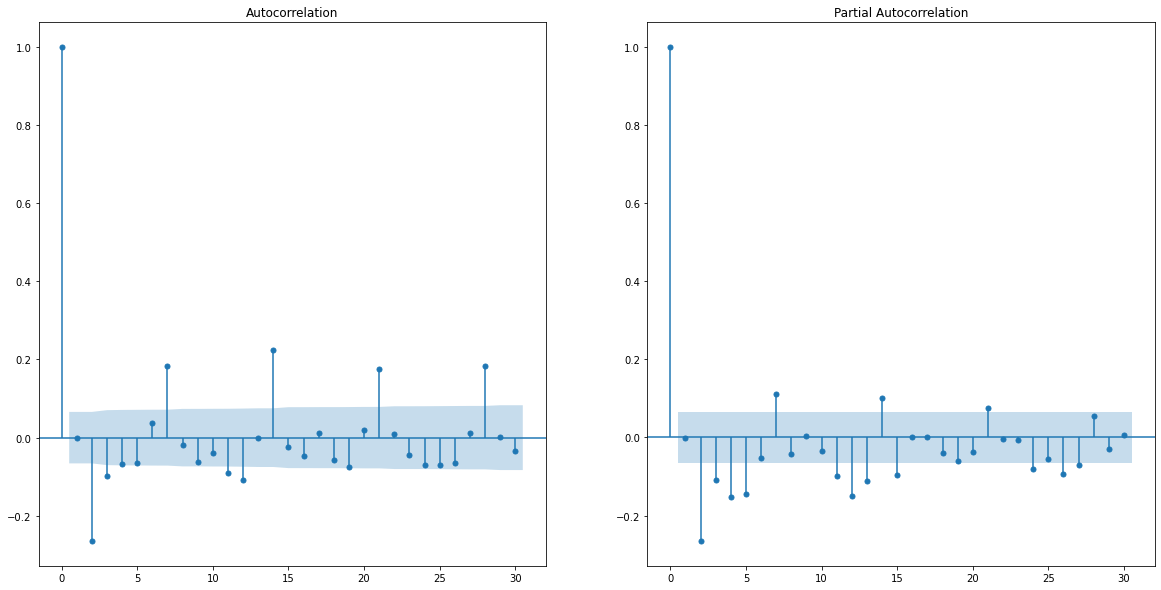

In [323]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(serie_3_diff, ax = ax1)
plot_pacf(serie_3_diff, ax = ax2)
plt.show()

## Ajuste da série_3

In [324]:
serie_3_treino = serie_3[pd.date_range(start="2019-06-11",end="2021-10-22")]
serie_3_validação = serie_3[pd.date_range(start="2021-10-23",end="2021-11-12")]

In [325]:
get_best_param_sarima(y = serie_3_treino, sazonalidade = 7)

The model with the smaller AIC:
ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:11514.164911821663


((1, 1, 1), (1, 1, 1, 7), 11514.164911821663)

In [326]:
mod = sm.tsa.statespace.SARIMAX(serie_3_treino,
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [327]:
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        UNITS_SOLD   No. Observations:                  865
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5752.082
Date:                           Wed, 02 Mar 2022   AIC                          11514.165
Time:                                   09:14:19   BIC                          11537.879
Sample:                               06-11-2019   HQIC                         11523.250
                                    - 10-22-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8290      0.019     43.044      0.000       0.791       0.867
ma.L1         -0.9597      0.012    -81.588

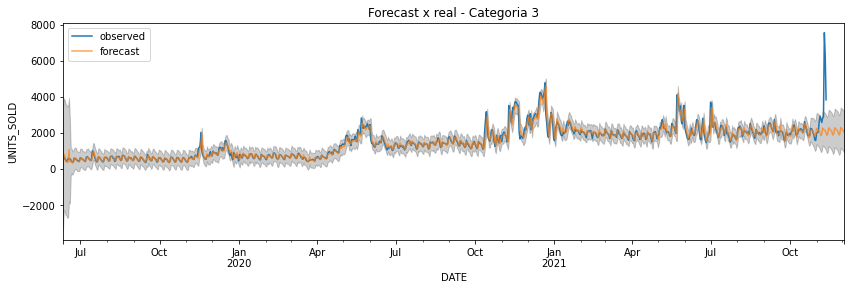

In [328]:
plot_series_sarima(serie_3[pd.date_range(start="2019-06-11",end="2021-11-12")], results, "Forecast x real - Categoria 3", 'observed','forecast', start_date = '2019-06-11',end_date='2021-12-03')

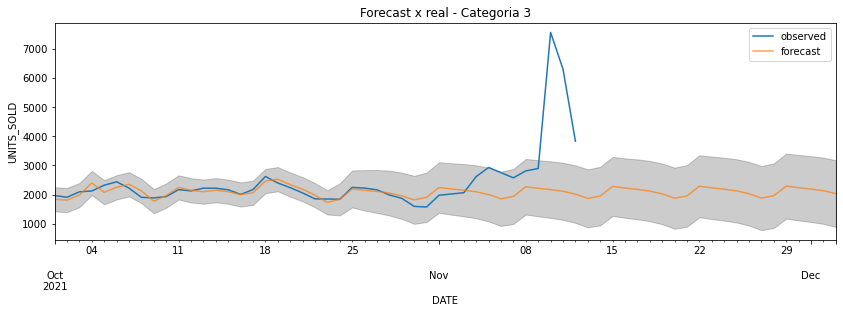

In [329]:
plot_series_sarima(serie_3[pd.date_range(start="2021-10-01",end="2021-11-12")], results, "Forecast x real - Categoria 3", 'observed','forecast', start_date = '2021-10-01',end_date='2021-12-03')

In [330]:
forecast = results.get_prediction(start='2019-06-11',end = '2021-12-03', dynamic=False).predicted_mean
pd.DataFrame({'real':serie_3,'forecast':forecast, 'difference':forecast - serie_3 }).tail(50)

real     forecast   difference
2021-10-15  2166.0  2099.741074   -66.258926
2021-10-16  2007.0  2004.793326    -2.206674
2021-10-17  2172.0  2064.589014  -107.410986
2021-10-18  2621.0  2464.073808  -156.926192
2021-10-19  2398.0  2527.930220   129.930220
2021-10-20  2239.0  2343.111924   104.111924
2021-10-21  2058.0  2184.287876   126.287876
2021-10-22  1854.0  1980.790088   126.790088
2021-10-23  1850.0  1733.441081  -116.558919
2021-10-24  1842.0  1840.357143    -1.642857
2021-10-25  2248.0  2194.734099   -53.265901
2021-10-26  2223.0  2147.088625   -75.911375
2021-10-27  2165.0  2108.187104   -56.812896
2021-10-28  1988.0  2053.818134    65.818134
2021-10-29  1872.0  1960.176520    88.176520
2021-10-30  1597.0  1821.475674   224.475674
2021-10-31  1577.0  1908.710917   331.710917
2021-11-01  1979.0  2244.374805   265.374805
2021-11-02  2022.0  2194.312067   172.312067
2021-11-03  2065.0  2152.102852    87.102852
2021-11-04  2618.0  2096.388680  -521.611320
2021-11-05  2929.0  2001.909663  -927.090337
2021-11-06  2751.0  1856.857938  -894.142062
2021-11-07  2576.0  1938.588893  -637.411107
2021-11-08  2812.0  2269.566065  -542.433935
2021-11-09  2894.0  2216.293823  -677.706177
2021-11-10  7551.0  2171.356694 -5379.643306
2021-11-11  6294.0  2113.453192 -4180.546808
2021-11-12  3829.0  2017.173581 -1811.826419
2021-11-13     NaN  1870.337306          NaN
2021-11-14     NaN  1950.576534          NaN
2021-11-15     NaN  2280.310701          NaN
2021-11-16     NaN  2226.042889          NaN
2021-11-17     NaN  2180.276974          NaN
2021-11-18     NaN  2121.690139          NaN
2021-11-19     NaN  2024.844792          NaN
2021-11-20     NaN  1877.524469          NaN
2021-11-21     NaN  1957.361790          NaN
2021-11-22     NaN  2286.762451          NaN
2021-11-23     NaN  2232.219967          NaN
2021-11-24     NaN  2186.226173          NaN
2021-11-25     NaN  2127.450621          NaN
2021-11-26     NaN  2030.448868          NaN
2021-11-27     NaN  1882.998110          NaN
2021-11-28     NaN  1962.727269          NaN
2021-11-29     NaN  2292.038247          NaN
2021-11-30     NaN  2237.421511          NaN
2021-12-01     NaN  2191.366153          NaN
2021-12-02     NaN  2132.539575          NaN
2021-12-03     NaN  2035.495525          NaN

In [331]:
erro = forecast[pd.date_range(start="2019-06-11",end="2021-11-12")] - serie_3

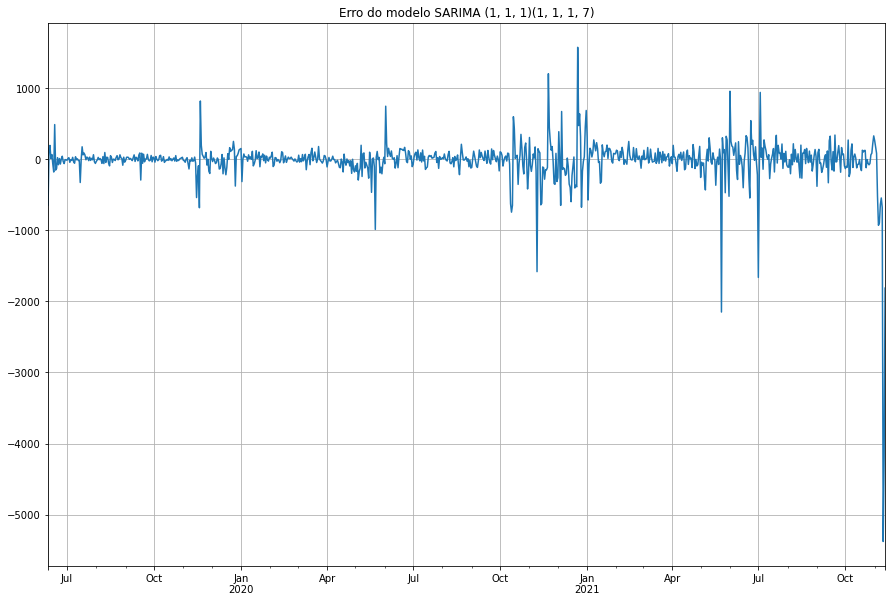

In [332]:
fig, ax = plt.subplots(figsize = (15,10))
erro.plot(grid = True)
ax.set_title('Erro do modelo SARIMA (1, 1, 1)(1, 1, 1, 7)')
plt.show()

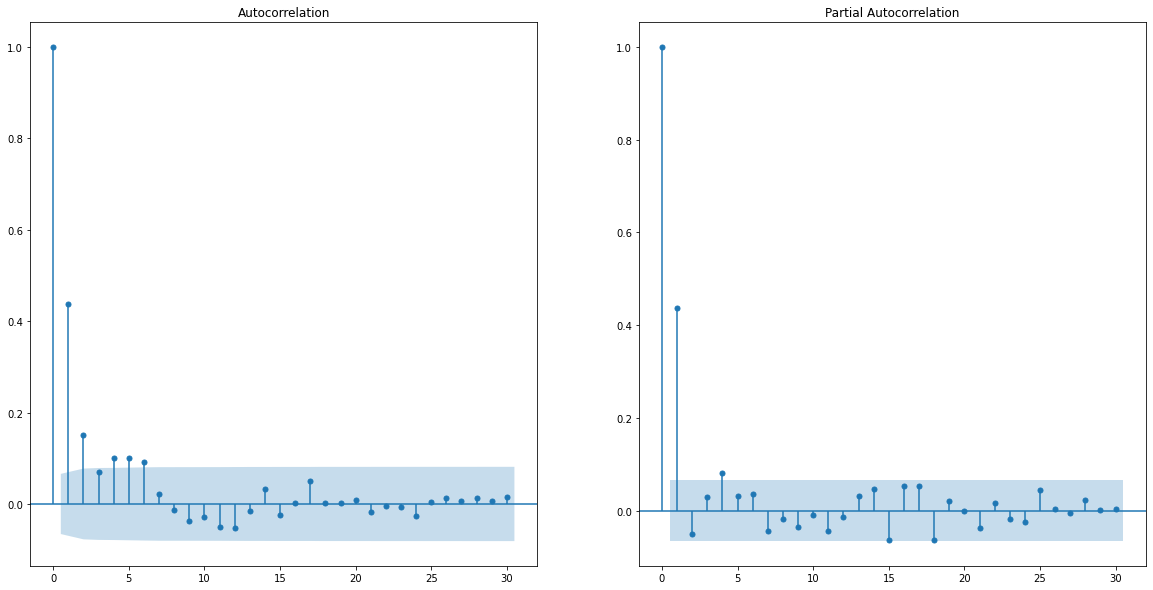

In [333]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
plot_acf(erro, ax = ax1)
plot_pacf(erro, ax = ax2)
plt.show()

Queremos testar se o erro gerado é aleatório com distribuição normal. Vamos utilizar para isto, o teste de Shapiro-Wilk.

In [335]:
erro.mean()

-16.30585099958047

In [336]:
erro.var()

103595.60729282988

In [334]:
shapiro_test = stats.shapiro(erro)
shapiro_test

ShapiroResult(statistic=0.4791966676712036, pvalue=7.006492321624085e-45)

Como o p-valor é menor que 0,05, ou seja, a probabilidade da estatística do teste ser maior que o valor observado é muito pequena, não rejeitamos a hipótese nula de que o erro é normalmente distribuído.